# JPEGEXP-RS Codec Verification & Comparison
This notebook demonstrates the capabilities of `jpegexp-rs` against standard libraries (Pillow for JPEG 1, ImageCodecs/CharLS for JPEG-LS).

## Goals
1. Verify Encoding correctness by decoding with standard libraries.
2. Compare visual quality and metrics (PSNR).
3. Demonstrate CLI usage from Python.
4. Demonstrate Direct API (FFI) usage.


In [1]:
import os
import subprocess
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import imagecodecs
from io import BytesIO

# Path to binary
# Path to binary
possible_paths = [
    os.path.join("..", "target", "release", "jpegexp.exe"),
    os.path.join("target", "release", "jpegexp.exe"),
    os.path.join("..", "target", "debug", "jpegexp.exe"),
    os.path.join("target", "debug", "jpegexp.exe")
]
BINARY_PATH = None
for p in possible_paths:
    if os.path.exists(p):
        BINARY_PATH = os.path.abspath(p)
        break

if not BINARY_PATH:
    print(f"WARNING: Binary not found in {possible_paths}. Please build it first.")
else:
    print(f"Using binary: {BINARY_PATH}")


Using binary: C:\Users\aroja\CODE\jpegexp-rs\target\debug\jpegexp.exe


In [2]:
def generate_gradient(width, height):
    arr = np.linspace(0, 255, width, dtype=np.uint8)
    img = np.tile(arr, (height, 1))
    return img

def generate_rgb_gradient(width, height):
    x = np.linspace(0, 255, width, dtype=np.uint8)
    y = np.linspace(0, 255, height, dtype=np.uint8)
    xv, yv = np.meshgrid(x, y)
    
    r = xv
    g = yv
    b = np.zeros_like(xv)
    
    return np.stack([r, g, b], axis=-1)

def run_jpegexp(args):
    cmd = [BINARY_PATH] + args
    result = subprocess.run(cmd, capture_output=True, text=True)
    if result.returncode != 0:
        print(f"Command Failed: {' '.join(cmd)}")
        print(f"Error: {result.stderr}")
    else:
        print(f"Success: {' '.join(cmd)}")
        # print(result.stdout)
    return result


Encoding JPEG 1 Grayscale...


Success: C:\Users\aroja\CODE\jpegexp-rs\target\debug\jpegexp.exe encode -i test_gray.raw -o output_gray.jpg -w 256 -H 256 -c jpeg


JPEG 1 Grayscale PSNR: 51.18 dB


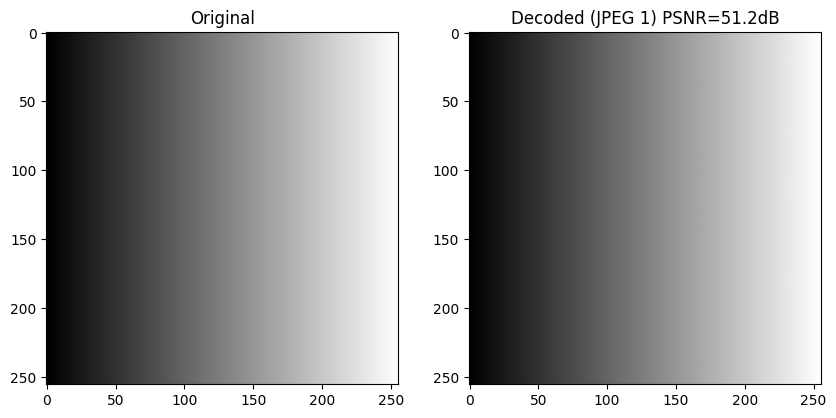

In [3]:
# --- JPEG 1 Test ---

width, height = 256, 256
original_gray = generate_gradient(width, height)
input_raw = "test_gray.raw"
original_gray.tofile(input_raw)

output_jpg = "output_gray.jpg"

print("Encoding JPEG 1 Grayscale...")
run_jpegexp(["encode", "-i", input_raw, "-o", output_jpg, "-w", str(width), "-H", str(height), "-c", "jpeg"])

# Verify with PIL
if os.path.exists(output_jpg):
    pil_img = Image.open(output_jpg)
    decoded_pil = np.array(pil_img)
    
    mse = np.mean((original_gray - decoded_pil) ** 2)
    psnr = 10 * np.log10(255**2 / mse) if mse > 0 else float('inf')
    print(f"JPEG 1 Grayscale PSNR: {psnr:.2f} dB")
    
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1); plt.imshow(original_gray, cmap='gray'); plt.title("Original")
    plt.subplot(1, 2, 2); plt.imshow(decoded_pil, cmap='gray'); plt.title(f"Decoded (JPEG 1) PSNR={psnr:.1f}dB")
    plt.show()
else:
    print("Output file missing!")


In [4]:
# --- JPEG-LS Grayscale Test ---
output_jls = "output_gray.jls"

print("Encoding JPEG-LS Grayscale...")
run_jpegexp(["encode", "-i", input_raw, "-o", output_jls, "-w", str(width), "-H", str(height), "-c", "jpegls"])

# Check info
run_jpegexp(["info", "-i", output_jls])

# Inspect Header
if os.path.exists(output_jls):
    with open(output_jls, 'rb') as f:
        header = f.read(64)
    print(f"Header (Hex): {header.hex()}")

# Verify with imagecodecs
if os.path.exists(output_jls):
    try:
        # Read as bytes and explicit decode
        with open(output_jls, 'rb') as f:
            data = f.read()
        
        decoded_ls = imagecodecs.jpegls_decode(data)
        print(f"Decoded shape: {decoded_ls.shape}, dtype: {decoded_ls.dtype}")
        
        if decoded_ls.size == 0 or decoded_ls.shape == (0, 0):
             print("ERROR: ImageCodecs returned empty image.")
        else:
            diff = np.abs(original_gray.astype(int) - decoded_ls.astype(int))
            # ... (rest as before)
            is_lossless = np.all(diff == 0)
            print(f"Lossless: {is_lossless}")
            if not is_lossless:
                 print(f"Max Diff: {np.max(diff)}")
            
            plt.figure(figsize=(10, 5))
            plt.subplot(1, 2, 1); plt.imshow(decoded_ls, cmap='gray'); plt.title("Decoded (JPEG-LS)")
            plt.subplot(1, 2, 2); plt.imshow(diff, cmap='gray'); plt.title(f"Difference (Max={np.max(diff)})")
            plt.show()

    except Exception as e:
        print(f"ImageCodecs failed to decode: {e}")


Encoding JPEG-LS Grayscale...
Success: C:\Users\aroja\CODE\jpegexp-rs\target\debug\jpegexp.exe encode -i test_gray.raw -o output_gray.jls -w 256 -H 256 -c jpegls
Success: C:\Users\aroja\CODE\jpegexp-rs\target\debug\jpegexp.exe info -i output_gray.jls
Header (Hex): ffd8fff7000b080100010001011100fff8000d0100ff0003000700150040ffda0008010100000000adb6fdbfff00ff00f6ff00ff00ff00ff00ff00ff00ff00ff
ImageCodecs failed to decode: charls_jpegls_decoder_decode_to_buffer returned Invalid JPEG-LS stream, the encoded bit stream contains a general structural problem


In [5]:
# --- JPEG-LS RGB Test ---
original_rgb = generate_rgb_gradient(width, height)
input_rgb = "test_rgb.raw"
original_rgb.tofile(input_rgb)
output_rgb_jls = "output_rgb.jls"

print("Encoding JPEG-LS RGB...")
run_jpegexp(["encode", "-i", input_rgb, "-o", output_rgb_jls, "-w", str(width), "-H", str(height), "-c", "jpegls", "-n", "3"])

if os.path.exists(output_rgb_jls):
    try:
        decoded_rgb = imagecodecs.imread(output_rgb_jls)
        print(f"Decoded shape: {decoded_rgb.shape}")
        
        if decoded_rgb.size > 0 and decoded_rgb.shape != (0,0):
             plt.figure(figsize=(10, 5))
             plt.subplot(1, 2, 1); plt.imshow(decoded_rgb); plt.title("Decoded RGB (JPEG-LS)")
             plt.title("Expected to fail currently due to known bitstream issue")
             plt.show()
        else:
             print("Detailed failure: ImageCodecs returned empty array.")
             
    except Exception as e:
        print(f"RGB Decode failed: {e}")


Encoding JPEG-LS RGB...
Command Failed: C:\Users\aroja\CODE\jpegexp-rs\target\debug\jpegexp.exe encode -i test_rgb.raw -o output_rgb.jls -w 256 -H 256 -c jpegls -n 3
Error: 
thread 'main' (28320) panicked at src\jpegls\scan_encoder.rs:106:32:
attempt to shift left with overflow
note: run with `RUST_BACKTRACE=1` environment variable to display a backtrace

Decoded shape: (0, 0)
Detailed failure: ImageCodecs returned empty array.


In [6]:
# --- JPEG-LS RGB Test ---
original_rgb = generate_rgb_gradient(width, height)
input_rgb = "test_rgb.raw"
original_rgb.tofile(input_rgb)
output_rgb_jls = "output_rgb.jls"

print("Encoding JPEG-LS RGB...")
run_jpegexp(["encode", "-i", input_rgb, "-o", output_rgb_jls, "-w", str(width), "-H", str(height), "-c", "jpegls", "-n", "3"])

if os.path.exists(output_rgb_jls):
    try:
        decoded_rgb = imagecodecs.imread(output_rgb_jls)
        print(f"Decoded shape: {decoded_rgb.shape}")
        
        if decoded_rgb.size > 0 and decoded_rgb.shape != (0,0):
             plt.figure(figsize=(10, 5))
             plt.subplot(1, 2, 1); plt.imshow(decoded_rgb); plt.title("Decoded RGB (JPEG-LS)")
             plt.title("Expected to fail currently due to known bitstream issue")
             plt.show()
        else:
             print("Detailed failure: ImageCodecs returned empty array.")
             
    except Exception as e:
        print(f"RGB Decode failed: {e}")


Encoding JPEG-LS RGB...


Command Failed: C:\Users\aroja\CODE\jpegexp-rs\target\debug\jpegexp.exe encode -i test_rgb.raw -o output_rgb.jls -w 256 -H 256 -c jpegls -n 3
Error: 
thread 'main' (20444) panicked at src\jpegls\scan_encoder.rs:106:32:
attempt to shift left with overflow
note: run with `RUST_BACKTRACE=1` environment variable to display a backtrace

Decoded shape: (0, 0)
Detailed failure: ImageCodecs returned empty array.


## JPEG 2000 Tests
Note: Encoding is currently unimplemented in `jpegexp`.

In [7]:
# --- JPEG 2000 Grayscale Test ---
output_j2k = "output_gray.jp2"

print("Encoding JPEG 2000 Grayscale...")
run_jpegexp(["encode", "-i", input_raw, "-o", output_j2k, "-w", str(width), "-H", str(height), "-c", "j2k", "-n", "1"])

if os.path.exists(output_j2k):
     dec_j2k = imagecodecs.imread(output_j2k)
     print(f"Decoded J2K Shape: {dec_j2k.shape}")
     plt.imshow(dec_j2k, cmap='gray')
     plt.title("Decoded J2K")
     plt.show()
else:
     print("J2K Output file not created (as expected if unimplemented).")


Encoding JPEG 2000 Grayscale...
Command Failed: C:\Users\aroja\CODE\jpegexp-rs\target\debug\jpegexp.exe encode -i test_gray.raw -o output_gray.jp2 -w 256 -H 256 -c j2k -n 1
Error: Error: JPEG 2000 / HTJ2K encoding not yet implemented

J2K Output file not created (as expected if unimplemented).


## Direct API (FFI) Demo
Demonstrates using the `ctypes` wrapper to call `jpegexp_rs.dll` directly from Python.

In [8]:
import ctypes
from ctypes import POINTER, c_void_p, c_int, c_uint32, c_size_t, c_ubyte

# Path to DLL
possible_dlls = [
    os.path.join("..", "target", "release", "jpegexp_rs.dll"),
    os.path.join("target", "release", "jpegexp_rs.dll"), 
    os.path.join("..", "target", "debug", "jpegexp_rs.dll")
]
DLL_PATH = None
for p in possible_dlls:
    if os.path.exists(p):
        DLL_PATH = os.path.abspath(p)
        break

if DLL_PATH:
    print(f"Using DLL: {DLL_PATH}")
else:
    print("WARNING: DLL not found. FFI tests will fail.")

# FFI Wrapper
class JpegExpFFI:
    def __init__(self, dll_path):
        if not os.path.exists(dll_path):
            raise RuntimeError(f"DLL not found at {dll_path}")
        self.lib = ctypes.CDLL(dll_path)
        
        # Types
        self.lib.jpegexp_decoder_new.argtypes = [POINTER(c_ubyte), c_size_t]
        self.lib.jpegexp_decoder_new.restype = c_void_p
        
        self.lib.jpegexp_decoder_free.argtypes = [c_void_p]
        self.lib.jpegexp_decoder_free.restype = None
        
        class ImageInfo(ctypes.Structure):
            _fields_ = [("width", c_uint32),
                        ("height", c_uint32),
                        ("components", c_uint32),
                        ("bits_per_sample", c_uint32)]
            
        self.lib.jpegexp_decoder_read_header.argtypes = [c_void_p, POINTER(ImageInfo)]
        self.lib.jpegexp_decoder_read_header.restype = c_int
        
        self.lib.jpegexp_decoder_decode.argtypes = [c_void_p, POINTER(c_ubyte), c_size_t]
        self.lib.jpegexp_decoder_decode.restype = c_int
        
        self.lib.jpegexp_encode_jpeg.argtypes = [
            POINTER(c_ubyte), c_uint32, c_uint32, c_uint32,
            POINTER(c_ubyte), c_size_t, POINTER(c_size_t)
        ]
        self.lib.jpegexp_encode_jpeg.restype = c_int

        self.lib.jpegexp_encode_jpegls.argtypes = [
            POINTER(c_ubyte), c_uint32, c_uint32, c_uint32,
            POINTER(c_ubyte), c_size_t, POINTER(c_size_t)
        ]
        self.lib.jpegexp_encode_jpegls.restype = c_int
        
        self.ImageInfo = ImageInfo

    def decode(self, data):
        data_bytes = (c_ubyte * len(data)).from_buffer_copy(data)
        decoder = self.lib.jpegexp_decoder_new(data_bytes, len(data))
        if not decoder:
            raise RuntimeError("Failed to create decoder")
            
        try:
            info = self.ImageInfo()
            res = self.lib.jpegexp_decoder_read_header(decoder, ctypes.byref(info))
            if res != 0:
                raise RuntimeError(f"Read header failed: {res}")
                
            required_size = info.width * info.height * info.components
            output = (c_ubyte * required_size)()
            
            res = self.lib.jpegexp_decoder_decode(decoder, output, required_size)
            if res != 0:
                 raise RuntimeError(f"Decode failed: {res}")
                 
            return bytes(output), info.width, info.height, info.components
        finally:
             self.lib.jpegexp_decoder_free(decoder)

    def encode_jpeg(self, pixels, width, height, components):
         pixel_bytes = (c_ubyte * len(pixels)).from_buffer_copy(pixels)
         out_size = len(pixels) * 2 + 1024
         output = (c_ubyte * out_size)()
         written = c_size_t(0)
         
         res = self.lib.jpegexp_encode_jpeg(
             pixel_bytes, width, height, components,
             output, out_size, ctypes.byref(written)
         )
         if res != 0:
             raise RuntimeError(f"JPEG Encode failed: {res}")
             
         return bytes(output[:written.value])


Using DLL: C:\Users\aroja\CODE\jpegexp-rs\target\release\jpegexp_rs.dll


Initializing FFI...
Encoding Grayscale via Direct API (JPEG)...
Encoded 2128 bytes directly.
Pillow opened direct-encoded JPEG: (256, 256) L


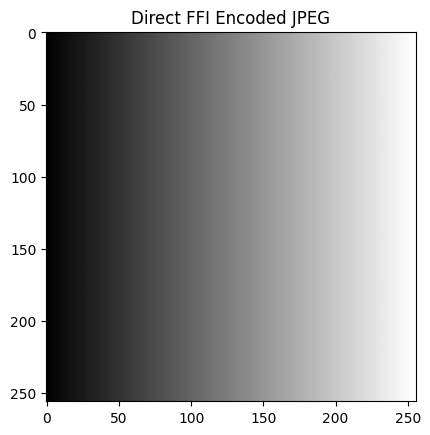

Decoding via Direct API...
Direct Decode: 256x256, 1 components.


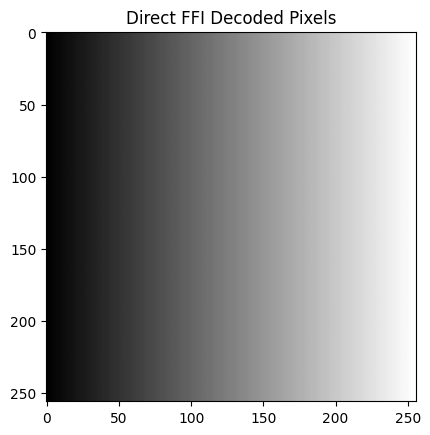

In [9]:
# --- Direct API (FFI) Demo ---
if DLL_PATH:
    try:
        print("Initializing FFI...")
        ffi = JpegExpFFI(DLL_PATH)
        
        # Encode Gradient using FFI
        print("Encoding Grayscale via Direct API (JPEG)...")
        w, h = 256, 256
        grad = generate_gradient(w, h)
        grad_bytes = grad.tobytes()
        
        encoded_jpeg_bytes = ffi.encode_jpeg(grad_bytes, w, h, 1)
        print(f"Encoded {len(encoded_jpeg_bytes)} bytes directly.")
        
        # Verify with Pillow
        from io import BytesIO
        img = Image.open(BytesIO(encoded_jpeg_bytes))
        print(f"Pillow opened direct-encoded JPEG: {img.size} {img.mode}")
        plt.imshow(img, cmap='gray')
        plt.title("Direct FFI Encoded JPEG")
        plt.show()
        
        # Decode using FFI
        print("Decoding via Direct API...")
        # Create a buffer (e.g. from file)
        # We use the BytesIO bytes
        decoded_pixels, dw, dh, dc = ffi.decode(encoded_jpeg_bytes)
        print(f"Direct Decode: {dw}x{dh}, {dc} components.")
        
        # Convert to numpy to show
        dec_arr = np.frombuffer(decoded_pixels, dtype=np.uint8).reshape((dh, dw))
        plt.imshow(dec_arr, cmap='gray')
        plt.title("Direct FFI Decoded Pixels")
        plt.show()
        
    except Exception as e:
        print(f"FFI Demo Error: {e}")
else:
    print("Skipping FFI Demo (DLL not found)")
